In [1]:
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from skimage.io import imread
from skimage.segmentation import mark_boundaries
from sklearn.metrics import roc_curve, auc
from skimage.color import label2rgb
import pandas as pd
from IPython.display import display
from glob import glob
from os.path import split, splitext, join
import tensorflow as tf
from keras.utils import multi_gpu_model

base_dir = os.path.realpath('D:\\all') 

Using TensorFlow backend.


In [2]:
all_img_df = pd.DataFrame(dict(path = glob(os.path.join(base_dir, 'train','*.*'))))

In [3]:
all_img_df['key_id'] = all_img_df['path'].map(lambda x : splitext(os.path.basename(x))[0])
all_img_df['car_id'] = all_img_df['key_id'].map(lambda x: x.split('_')[0])
all_img_df['mask_path'] = all_img_df['path'].map(lambda x: x.replace('train', 'train_masks').replace('.jpg', '_mask.gif'))
all_img_df['exists'] = all_img_df['mask_path'].map(os.path.exists)

In [4]:
def read_diff_img(c_row):
    t0_img = imread(c_row['path'])[:,:,0:3]
    cg_img = imread(c_row['mask_path'], as_grey=True)
    return (t0_img, cg_img)

    

In [5]:
from sklearn.model_selection import train_test_split
def train_test_split_on_group(in_df, col_id, **kwargs):
    group_val = np.unique(in_df[col_id])
    train_ids, test_ids = train_test_split(group_val, **kwargs)
    return in_df[in_df[col_id].isin(train_ids)], in_df[in_df[col_id].isin(test_ids)]

train_df, valid_df = train_test_split_on_group(all_img_df, col_id = 'car_id', random_state=2018, test_size=0.1)
valid_df, test_df = train_test_split_on_group(valid_df, col_id = 'car_id', random_state = 2018, test_size = 0.5)
print(train_df.shape[0], 'training images')
print(valid_df.shape[0], 'validation images')
print(test_df.shape[0], 'test images')


4576 training images
256 validation images
256 test images


In [6]:
#Augmenting data
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

dg_args = dict(featurewise_center = False,
              samplewise_center = False,
              rotation_range = 5,
              width_shift_range = 0.01,
              height_shift_range = 0.01,
              shear_range = 0.01,
              zoom_range = [0.9, 1.1],
              horizontal_flip = True,
              vertical_flip = False,
              fill_mode = 'nearest',
              data_format = 'channels_last',
              preprocessing_function = preprocess_input)
IMG_SIZE = (512, 512)
default_batch_size = 8
core_idg = ImageDataGenerator(**dg_args)
mask_args = dg_args.copy()
mask_args['preprocessing_function'] = lambda x:x/255.0
mask_idg = ImageDataGenerator(**mask_args)

In [7]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, class_mode='sparse', **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = ''
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [8]:
def make_gen(img_gen, mask_gen, in_df, batch_size = default_batch_size, seed=None, shuffle=True):
    if seed is None:
        seed = np.random.choice(range(9999))
    flow_args = dict(target_size = IMG_SIZE,
                    batch_size = batch_size,
                    seed = seed,
                    shuffle = shuffle,
                    y_col = 'key_id')
    t0_gen = flow_from_dataframe(img_gen, in_df,
                                 path_col = 'path',
                                color_mode = 'rgb',
                                **flow_args)
    dm_gen = flow_from_dataframe(mask_gen, in_df,
                                path_col = 'mask_path',
                                color_mode = 'grayscale',
                                **flow_args)
    
    for (t0_img, _), (dm_img, _) in zip(t0_gen, dm_gen):
        yield [t0_img], dm_img
train_gen = make_gen(core_idg, mask_idg, train_df)
valid_gen = make_gen(core_idg, mask_idg, valid_df, seed=0, shuffle= False)
test_gen = make_gen(core_idg, mask_idg, test_df, seed=0, shuffle=False, batch_size =2*default_batch_size)
[t0_img], dm_img = next(train_gen)

print(t0_img.shape, t0_img.max())
print(dm_img.shape, dm_img.max(), dm_img.mean())

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 4576 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 4576 images
(8, 512, 512, 3) 151.061
(8, 512, 512, 1) 1.0 0.23762156


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(8, 512, 512, 1)


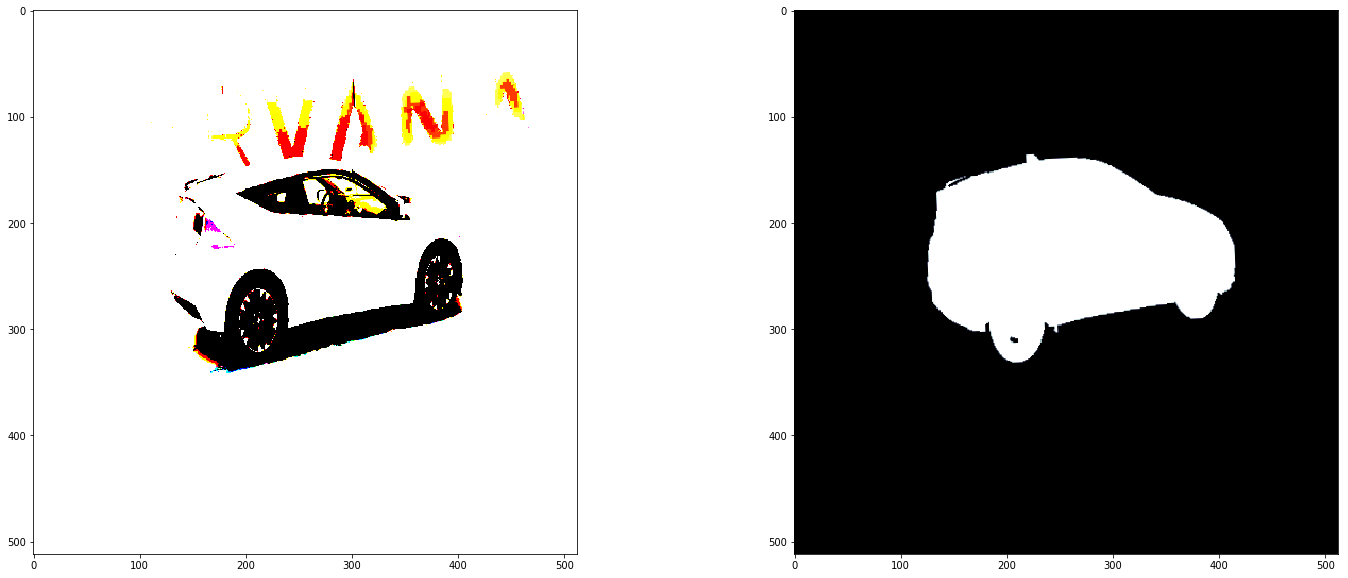

In [9]:
#import skimage
#from skimage.util.montage import montage2d
#n_rgb = lambda x: np.stack([(x[:, :, i]-x[:, :, i].min())/(x[:, :, i].max()-x[:, :, i].min()) for i in range(x.shape[2])], 2)[:, :, ::-1]
#nn_rgb = lambda x: n_rgb(np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1))
print(dm_img.shape)
fig, (ax1, ax3) = plt.subplots(1, 2, figsize = (25, 10))
ax1.imshow((t0_img[5, :, :, :].reshape(512,512,3)), cmap = 'bone')
#ax1.set_title('$T_0$ Image')
ax3.imshow((dm_img[5, :, :, 0].reshape(512,512)), cmap = 'bone')
#ax3.set_title('$\Delta$T Mask')

In [10]:
#building the model
from keras.applications.vgg16 import VGG16 as PTModel
base_pretrained_model = PTModel(input_shape = t0_img.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False

In [11]:
from collections import defaultdict, OrderedDict
from keras.models import Model
layer_size_dict = defaultdict(list)
inputs = []
for lay_idx, c_layer in enumerate(base_pretrained_model.layers):
    if not c_layer.__class__.__name__ == 'InputLayer':
        layer_size_dict[c_layer.get_output_shape_at(0)[1:3]] += [c_layer]
    else:
        inputs +=[c_layer]
layer_size_dict = OrderedDict(layer_size_dict.items())
for k,v in layer_size_dict.items():
    print(k, [w.__class__.__name__ for w in v])
        

(512, 512) ['Conv2D', 'Conv2D']
(256, 256) ['MaxPooling2D', 'Conv2D', 'Conv2D']
(128, 128) ['MaxPooling2D', 'Conv2D', 'Conv2D', 'Conv2D']
(64, 64) ['MaxPooling2D', 'Conv2D', 'Conv2D', 'Conv2D']
(32, 32) ['MaxPooling2D', 'Conv2D', 'Conv2D', 'Conv2D']
(16, 16) ['MaxPooling2D']


In [12]:
#tahe the last layer in each shape and make it into an output
pretrained_encoder = Model(inputs = base_pretrained_model.get_input_at(0), outputs = [v[-1].get_output_at(0) for k,v in layer_size_dict.items()])
pretrained_encoder.trainable = False
n_outputs = pretrained_encoder.predict([t0_img])
for c_out, (k,v) in zip(n_outputs, layer_size_dict.items()):
    print(c_out.shape, 'expected', k)

(8, 512, 512, 64) expected (512, 512)
(8, 256, 256, 128) expected (256, 256)
(8, 128, 128, 256) expected (128, 128)
(8, 64, 64, 512) expected (64, 64)
(8, 32, 32, 512) expected (32, 32)
(8, 16, 16, 512) expected (16, 16)


In [13]:
# Build UNET
from keras.layers import Input, Conv2D, concatenate, UpSampling2D, BatchNormalization, Activation, Cropping2D, ZeroPadding2D
x_wid, y_wid = t0_img.shape[1:3]
in_t0 = Input(t0_img.shape[1:], name = 'T0_Image')
wrap_encoder = lambda i_layer: {k:v for k,v in zip(layer_size_dict.keys(), pretrained_encoder(i_layer))}
t0_outputs = wrap_encoder(in_t0)
lay_dims = sorted(t0_outputs.keys(), key=lambda x:x[0])
skip_layers = 2
last_layer = None

for k in lay_dims[skip_layers:]:
    cur_layer = t0_outputs[k]
    channel_count = cur_layer._keras_shape[-1]
    cur_layer = Conv2D(channel_count//2, kernel_size=(3,3), padding='same', activation='linear')(cur_layer)
    cur_layer = BatchNormalization()(cur_layer) # gotta keep an eye on that internal covariant shift
    cur_layer = Activation('relu')(cur_layer)
    
    if last_layer is None:
        x = cur_layer
    else:
        last_channel_count = last_layer._keras_shape[-1]
        x = Conv2D(last_channel_count//2, kernel_size=(3,3), padding = 'same')(last_layer)
        x = UpSampling2D((2,2))(x)
        x = concatenate([cur_layer, x])
    last_layer = x
final_output = Conv2D(dm_img.shape[-1], kernel_size=(1,1), padding='same', activation='sigmoid')(last_layer)
crop_size = 20
final_output = Cropping2D((crop_size, crop_size))(final_output)
final_output = ZeroPadding2D((crop_size, crop_size))(final_output)

unet_model = Model(inputs = [in_t0],
                   outputs = [final_output])

unet_model.summary()

    

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
T0_Image (InputLayer)           (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 [(None, 512, 512, 64 14714688    T0_Image[0][0]                   
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 256)  1179904     model_1[1][3]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 256)  1024        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [111]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true*y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
unet_model.compile(optimizer=Adam(1e-3, decay=1e-6), loss='binary_crossentropy', metrics=[dice_coef, 'binary_accuracy', true_positive_rate])
loss_history = []
    

In [119]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('vgg_unet')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, reduceLROnPlat, early]

C:\Anaconda3\envs\dl\lib\site-packages\keras\callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [120]:

loss_history += [unet_model.fit_generator(make_gen(core_idg, mask_idg, train_df), 
                                         steps_per_epoch=min(100, train_df.shape[0]//t0_img.shape[0]), 
                                         epochs = 5, 
                                         validation_data = valid_gen,
                                          validation_steps = valid_df.shape[0]//t0_img.shape[0],
                                         callbacks = callbacks_list,
                                          workers = 2
                                          )]

## Ignore next message from keras, values are replaced anyways
Epoch 1/5
Found 0 images belonging to 0 classes.
Reinserting dataframe: 4576 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 4576 images
 64/100 [==================>...........] - ETA: 29s - loss: 0.0625 - dice_coef: 0.9765 - binary_accuracy: 0.9883 - true_positive_rate: 0.9789

ResourceExhaustedError: OOM when allocating tensor with shape[8,128,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: concatenate_3/concat = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32, _class=["loc:@training_2/Adam/gradients/concatenate_3/concat_grad/Slice"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](activation_4/Relu, concatenate_3/concat-1-TransposeNHWCToNCHW-LayoutOptimizer, concatenate_3/concat-2-LayoutOptimizer)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: metrics_2/true_positive_rate/Mean/_1961 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2597_metrics_2/true_positive_rate/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


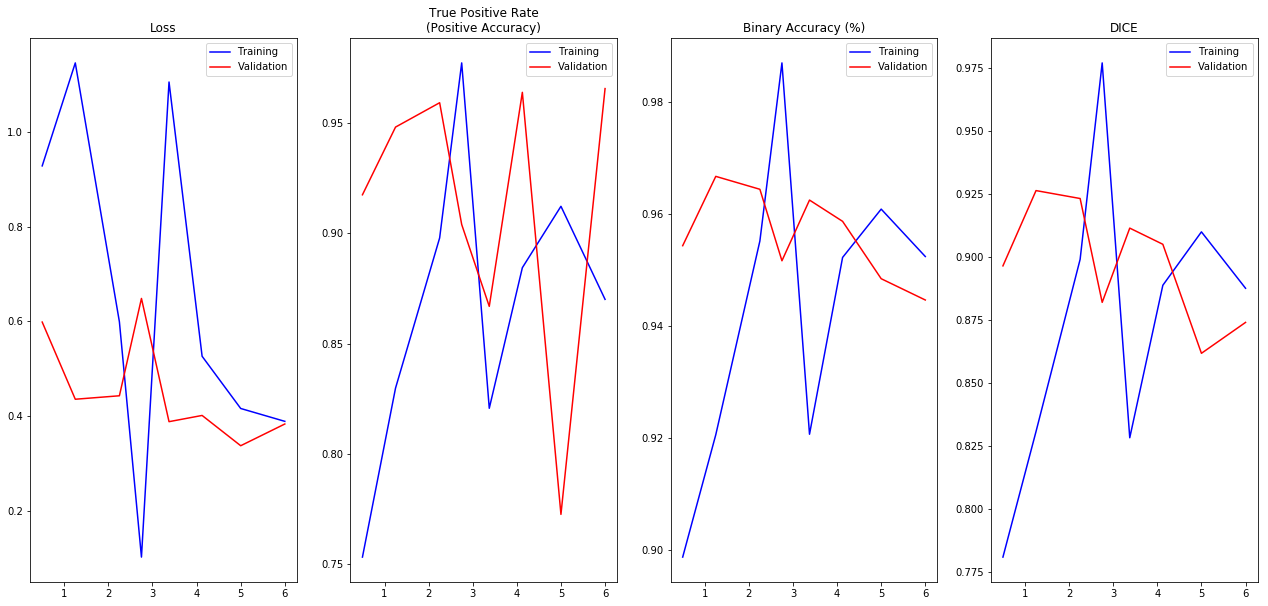

In [108]:

def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)

In [116]:
unet_model.load_weights('vgg_unet_weights.best.hdf5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


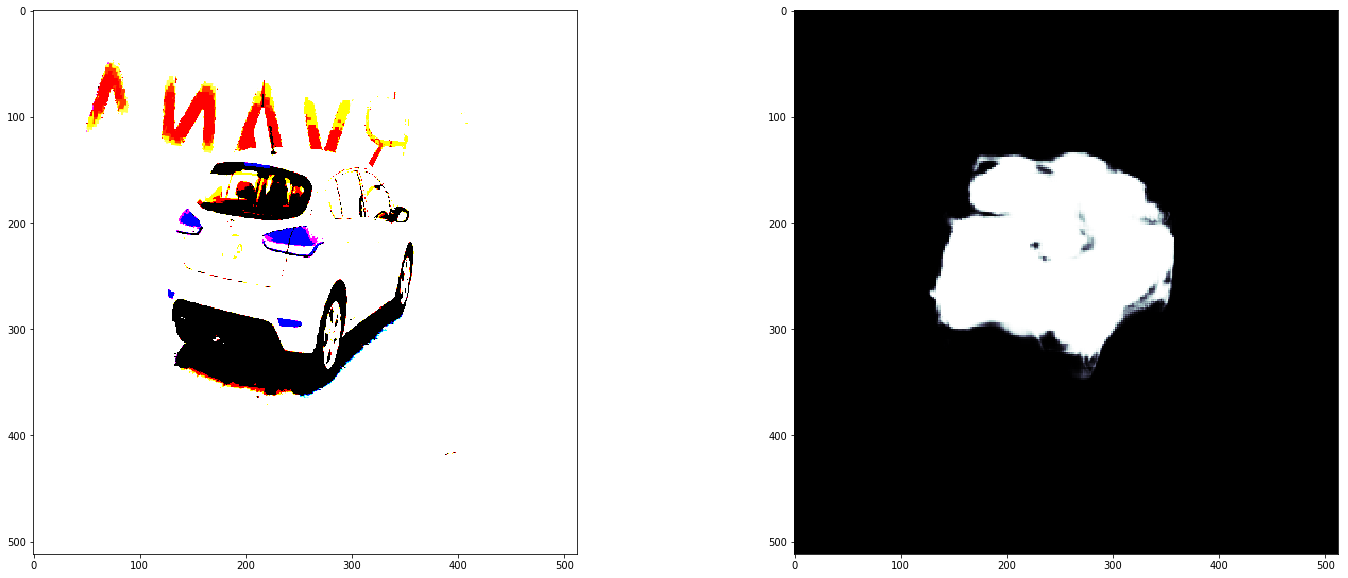

In [117]:
[t0_img], dm_img = next(test_gen)
dm_pred = unet_model.predict([t0_img])
fig, (ax1, ax3) = plt.subplots(1, 2, figsize = (25, 10))
ax1.imshow((t0_img[7, :, :, :].reshape(512,512,3)), cmap = 'bone')
ax3.imshow((dm_pred[7,:,:,:].reshape(512,512)), cmap = 'bone')

(1, 512, 512, 3)


C:\Anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


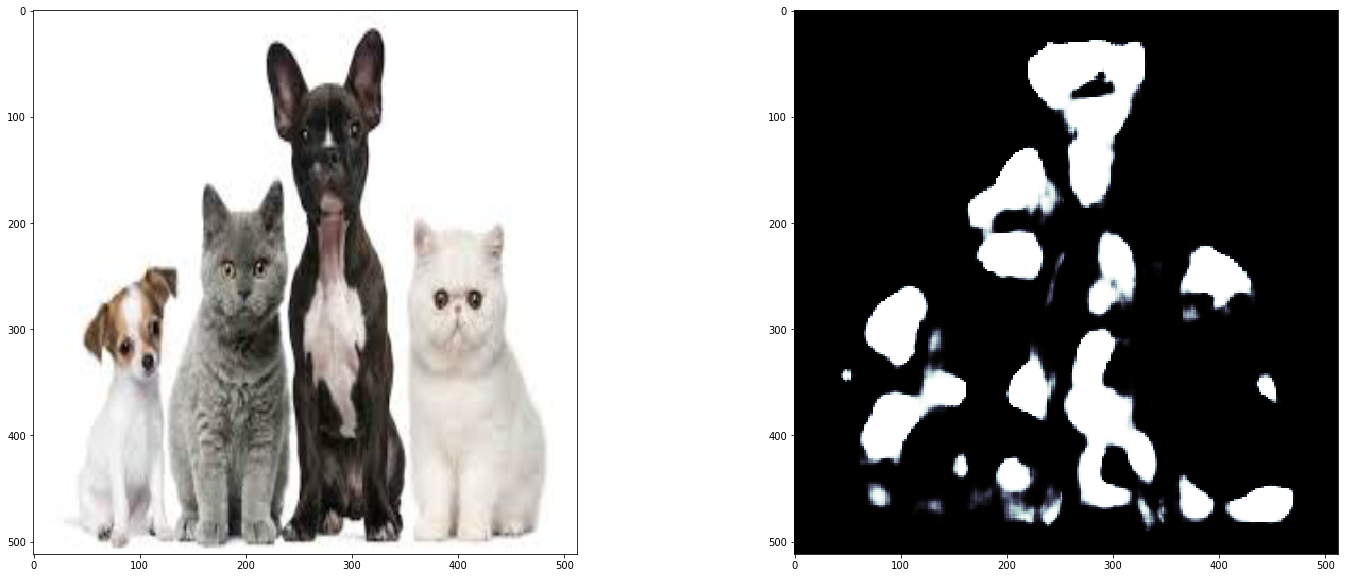

In [118]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
import os
from scipy.misc import imresize
from PIL import Image
path = os.getcwd()
original_img = load_img(os.path.join(path,'catdog.jpg'))
i = imresize(original_img,[512,512,3])
resized_img = np.reshape(i,[1,512,512,3])
dims = [512, 512]
#resized_img = tf.reshape(i, [1,512,512,3])
print(resized_img.shape)
dm_pred = unet_model.predict(resized_img)
fig, (ax1, ax3) = plt.subplots(1, 2, figsize = (25, 10))
ax1.imshow((resized_img.reshape(512,512,3)), cmap = 'bone')
ax3.imshow((dm_pred[:,:,:,:].reshape(512,512)), cmap = 'bone')   